# Evaluation
This Notebook loads a pre-trained model from google drive and evaluates it on a previously generated test-set.
Depending on which part of the job ad the model was trained on, the corresponding test set has to be chosen and some cells have to adjusted (see comments). The results will be presented in a separate notebook.


# Preparation, Imports and Function definitions


In [0]:
!pip install transformers

In [0]:
# mount to drive
# necessary for loading model, tokenizer and data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
    

import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")



Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Read in and clean data


In [0]:
# Import test data 
import pandas as pd
url='https://raw.githubusercontent.com/k-amini/NLP_RNN/master/study_data/study_description.csv'

df = pd.read_csv(url)
df.fraudulent = [0 if i=='f' else 1 for i in df.fraudulent ]


In [0]:
df['description']=df['description'].fillna('nann')

The below cell was used to create a big df where all parts of the job ads are stored. You can ignore it.

In [0]:
# # create big df
# df_requirements=pd.read_csv('https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_deduplicated_data/test_requirements.csv')
# df_benefits=pd.read_csv('https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_deduplicated_data/test_benefits.csv')
# df_company_profile=pd.read_csv('https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_deduplicated_data/test_company_profile.csv')
#df_description=pd.read_csv('https://raw.githubusercontent.com/k-amini/NLP_RNN/master/clean_deduplicated_data/test_description.csv')

# df_big = df_description.copy()
# df_big['fraudulent']=[0 if i=='f' else 1 for i in df_big.fraudulent ]
# df_big['company_profile']=df_company_profile.company_profile
# df_big['requirements']=df_requirements.requirements
# df_big['benefits']=df_benefits.benefits

In [0]:
# get text blocks and corresponding labels
texts=df.description.values
text_labels=df.fraudulent.values

# Load Model and Tokenizer
We will load the previously trained model from google drive. You can adjust the load_path accordingly.

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from transformers import *
# Load a trained model and vocabulary 
load_path = "/content/drive/My Drive/Colab Notebooks/balanced_dup_removed/description/model_save/"
# uncomment if unbalanced is desired
#load_path = "/content/drive/My Drive/Colab Notebooks/unbalanced/model_save/"

model = BertForSequenceClassification.from_pretrained(load_path)
tokenizer = BertTokenizer.from_pretrained(load_path)
# Copy the model to the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Tokenize
We have to prepare (tokenize etc.) the test set the same way as the train set.

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_own = []

# For every sentence...
for sent in texts:
  #print(sent)
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
  encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = 512,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
  input_ids_own.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids_own[0])

Original:  the group has raised a fund for the purchase of homes in the southeast. the student on this project will help them build their investments from the ground up and will help with the analysis and modeling of their investments. we should be looking for someone with a strong general finance skills and has a lot of entrepreneurial ability.
Token IDs: [101, 1996, 2177, 2038, 2992, 1037, 4636, 2005, 1996, 5309, 1997, 5014, 1999, 1996, 4643, 1012, 1996, 3076, 2006, 2023, 2622, 2097, 2393, 2068, 3857, 2037, 10518, 2013, 1996, 2598, 2039, 1998, 2097, 2393, 2007, 1996, 4106, 1998, 11643, 1997, 2037, 10518, 1012, 2057, 2323, 2022, 2559, 2005, 2619, 2007, 1037, 2844, 2236, 5446, 4813, 1998, 2038, 1037, 2843, 1997, 10670, 4818, 3754, 1012, 102]


# Pad (important: Use same padding as used in training - 512)

In [0]:
# Now for own data
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids_own = pad_sequences(input_ids_own, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


# Create attention masks

In [0]:
# Create attention masks
attention_masks_own = []

# For each sentence...
for sent in input_ids_own:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks_own.append(att_mask)

# Convert everything to correct datatypes

In [0]:

# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.

input_ids = torch.tensor(input_ids_own)
labels = torch.tensor(text_labels)
masks = torch.tensor(attention_masks_own)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# now for own data
batch_size = 8

# Create the DataLoader for our training set.
data_ = TensorDataset(input_ids, masks, labels)
sampler_ = SequentialSampler(data_)
dataloader_ = DataLoader(data_, sampler=sampler_, batch_size=batch_size)

# Helper functions for accuracy evaluation

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# recalculating probabilities from logits for one batch
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))
def get_proba_batch(batch):
  return [sigmoid(logits[i][1])/(sigmoid(logits[i][0])+sigmoid(logits[i][1])) for i in range(len(batch))]



# Evaluate model and create new column in df

In [0]:
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
preds_all=[]
probas_all=[]
# Evaluate data for one epoch
for batch in dataloader_:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds_all += np.argmax(logits,axis=1).tolist()
    probas_all += get_proba_batch(logits)
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))

# ad predictions to dataframe
df['preds']=np.array(preds_all)
df['pred_proba']=np.array(probas_all)



Running Validation...
  Accuracy: 0.95
  Validation took: 0:00:16


In [0]:
df.head()

,fraudulent,description,preds,pred_proba
0,1,the group has raised a fund for the purchase o...,0,0.309939
1,1,sales executive,1,0.958895
2,1,"a newly established company seeks outgoing, fr...",1,0.984503
3,1,administrative assistantessential job responsi...,1,0.982772
4,0,normal 0 false false false en-us x-none x-none...,0,0.021576


# Save output 
Save output as csv and copy it to google drive. Uncomment if desired

In [0]:
# df_big.to_csv('Bert_balanced_nodupl_5epochs_test_preds.csv')
# !cp  ./Bert_balanced_nodupl_5epochs_test_preds.csv "/content/drive/My Drive/Colab Notebooks/balanced_dup_removed/"

# Create confusion matrix

In [0]:
import seaborn as sns
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()

from sklearn.metrics import roc_curve, roc_auc_score
def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    """Plots ROC AUC
    """
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column],drop_intermediate = False)
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

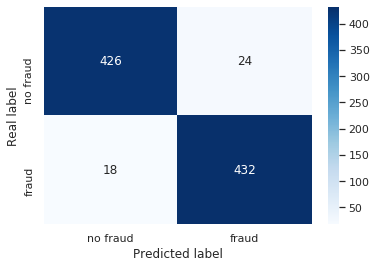

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(df.fraudulent,df.preds)
plot_confusion_matrix(cm,class_labels=['no fraud','fraud'])